In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd "/content/gdrive/MyDrive/IA"
%ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/IA
'Documentación '/   Indicadores.csv   us2022q2a.csv   usfirms2022.csv


In [ ]:
df=pd.read_csv ("Indicadores.csv")

In [ ]:
df = df.sort_values(by='Periodo')

In [ ]:
df['ln'] = np.log(df['Valor'])

**Estacionalidad**

In [ ]:
from statsmodels.tsa.stattools import adfuller
print("Fuller test")
print(adfuller(df['ln']))

Fuller test
(-1.2101278671871099, 0.6692238553809415, 17, 337, {'1%': -3.4499043309021955, '5%': -2.870154885338925, '10%': -2.5713597190254385}, -1529.5205632564598)


Una variable se considera estacionaria si no presenta tendendicas de cambio a lo largo del tiempo de manera directa, para usar un modelo sarima es necesario usar una variable estacionaria por lo que usaremos la prueba de adfuller para saber si es estacionaria, en este caso en especifico nos arroja el resultado de NO estacionaria. Por lo que hare agustes para que se vuelva estacionaria.

In [ ]:
df['lag']= df['ln']  - np.log(df['Valor']).shift(12)

haremos la prueba de estacionaridad para el cambio anual de la variable.

In [ ]:
df2 = df
df2 = df2.dropna()

In [55]:
from statsmodels.tsa.stattools import adfuller
print("Fuller test")
print(adfuller(df2['lag']))

Fuller test
(-3.767291622294237, 0.0032602635598127376, 17, 325, {'1%': -3.450632157720528, '5%': -2.870474482366864, '10%': -2.5715301325443787}, -1446.8289417719393)


Podemos observar que ya tenemos un pvalue menor a 0.05 en la prueba por lo que ya se tiene una variable estacionari.

ANALISIS DE AUTOCORRELACION

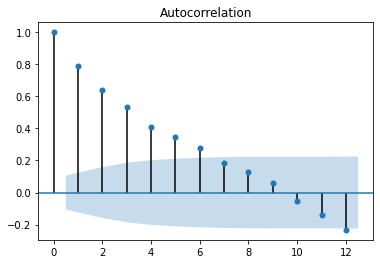

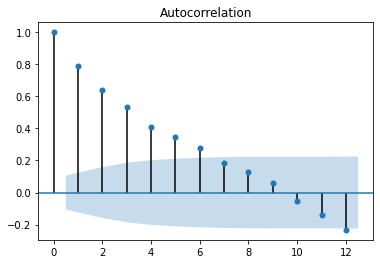

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df['shift12']= df['ln']  - np.log(df['Valor']).shift(12)
temp = df['shift12'].dropna()
plot_acf(temp, lags = 12)

Con la autocorrelacion podemos saber si una varibale depende de una misma en el pasado esto nos permitira saber que tipo de parametros utiliaremos en el modelo

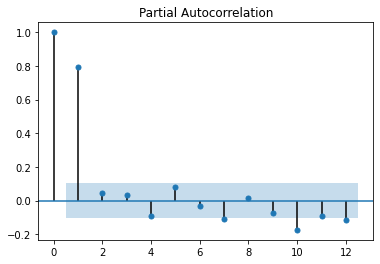

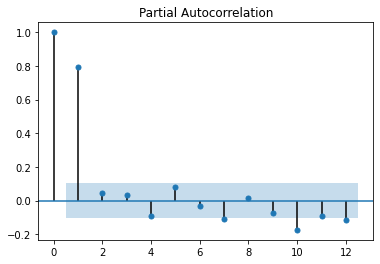

In [ ]:
plot_pacf(temp, lags = 12)

Existe un comportamiento en el que hay correlacion con el periodo mas cercano en el pasado, po lo tanto usaremos un valor de P=1 en el modelo

**Creación del modelo**

In [39]:
import statsmodels.api as sm

m1= sm.tsa.statespace.SARIMAX(df['ln'], order=(0,0,0), seasonal_order = (0,1,0,12), trend='c',  simple_differencing=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [40]:
m1_f= m1.fit(disp = 0)

In [41]:
m1_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                  DS12.ln   No. Observations:                  343
Model:             SARIMAX(0, 0, 0, 12)   Log Likelihood                 573.820
Date:                  Tue, 25 Oct 2022   AIC                          -1143.639
Time:                          05:20:33   BIC                          -1135.964
Sample:                               0   HQIC                         -1140.582
                                  - 343                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0196      0.003      7.345      0.000       0.014       0.025
sigma2         0.0021   7.61e-05     27.091      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                 216.20   Jarque-Bera (JB):              1024.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -1.24
Prob(H) (two-sided):                  0.06   Kurtosis:                        11.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ya que entrene el modelo voy a verificar si es necesario calibrarlo mediante el analisis de susresiduos

In [42]:
r = m1_f.resid

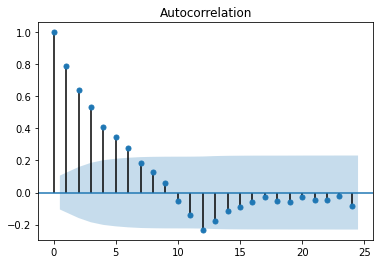

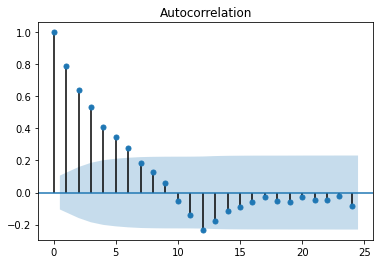

In [43]:
plot_acf(r, lags = 24)

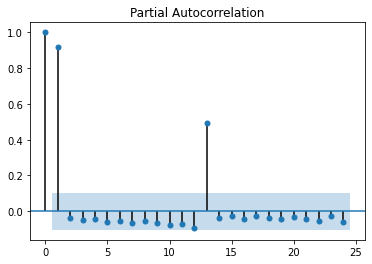

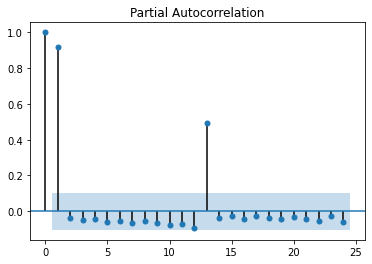

In [56]:
plot_pacf(r, lags = 24)

En los residuos encontre una correlación muy alta con el lag 12, esto nos dice, que existe una perioricidad anual por lo que asignamos el valor de Q=1

In [49]:
m1= sm.tsa.statespace.SARIMAX(df['ln'], order=(1,0,0), seasonal_order = (0,1,0,12), trend='c',  simple_differencing=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [50]:
m1_f= m1.fit(disp = 0)

In [51]:
r = m1_f.resid

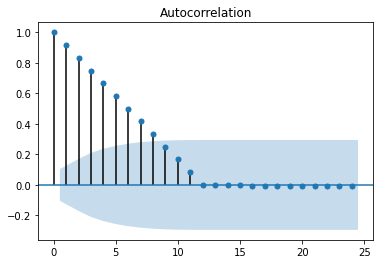

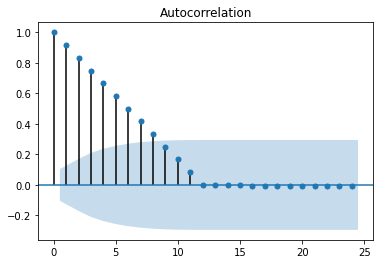

In [52]:
plot_acf(r, lags = 24)

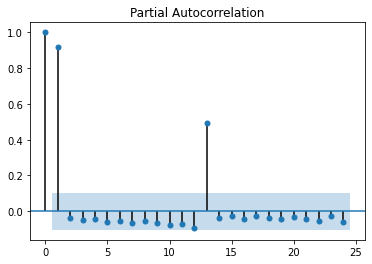

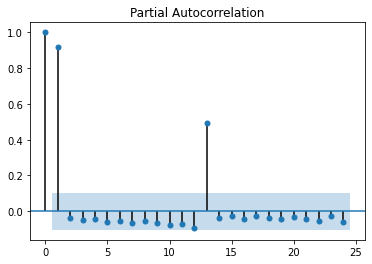

In [57]:
plot_pacf(r, lags = 24)

Ya no existen correlaciones entre las variables de residuo por lo que hemos finalizado.

Ahora con el modelo creado puedo usar la funcion forecast para que el modelo prediga el futuro 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


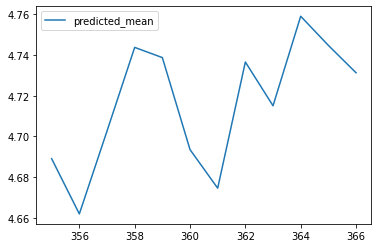

In [53]:
my_forecast  = (m1_f.forecast(steps=12))
grafica = pd.DataFrame(my_forecast)
grafica.plot()